#  DCGAN Improvement 1

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import mean
from numpy.random import randn
from numpy.random import randint
from numpy.random import choice
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Concatenate
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import tensor_shape
from tensorflow.python.eager import def_function
from tensorflow.python.keras import initializers
from keras.initializers import RandomNormal
from tensorflow.python.keras import backend as K
from keras.utils import np_utils
from keras.utils import plot_model
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from numpy import asarray
import pickle

Using TensorFlow backend.


### Data Preprocessing

In [2]:
#get the list of all files in the specified directory
path = 'CK PLUS/CK+48'
labels_list = os.listdir(path)
labels_list

images_data_list = []

for dataset in labels_list:
    imgs_per_label_list = os.listdir(path+'/'+ dataset)
    for image in imgs_per_label_list:
        #load the image in grayscale mode
        input_image = cv2.imread(path + '/'+ dataset + '/'+ image,0)
        #change the width and height of the original image to 48*48
        image_resized = cv2.resize(input_image,(48,48))
        #append the resized image to the images_data_list
        images_data_list.append(image_resized)

#convert data to numpy array
images_data = np.array(images_data_list)
images_data.shape

number_of_classes = 7
number_of_samples = images_data.shape[0]

#create an 1D array of zeros with 981 elements.
labels = np.zeros(number_of_samples,dtype='int64')

labels[0:206]=0 #207
labels[207:260]=1 #54
labels[261:335]=2 #75
labels[336:584]=3 #249
labels[585:668]=4 #84
labels[669:803]=5 #135
labels[804:980]=6 #177

#labels array
y = np.array(labels)
X = images_data.reshape(images_data.shape[0],48,48,1) 

#Shuffle the dataset
X,y = shuffle(X,y, random_state=42)

#Convert data into a float32 array 
X = X.astype('float32')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5

df = pd.read_csv('icml_face_data.csv')
df_split = np.array_split(df, 3)
df = df_split[0]

df['emotion']=df['emotion'].replace({0:8,1:9,2:10,3:11,4:12,5:13,6:14}).replace({8:5,9:6,10:2,11:0,12:4,13:3,14:7})
df['emotion'].unique()

def preprocessing_data(df):  
    img_array = np.zeros(shape=(len(df), 48, 48))
    img_label = np.array(list(map(int, df['emotion']))) #map() function is used to iterate over an array
    
    for i, row in enumerate(df.index):
        img = np.fromstring(df.loc[row,' pixels'], dtype=int, sep=' ')
        img = np.reshape(img, (48, 48))
        img_array[i] = img
        
    return img_array, img_label

X_img, y_labels = preprocessing_data(df)

#Reshape images into (48,48,1) shape
X_img = X_img.reshape((X_img.shape[0], 48, 48, 1))
#Convert data into a float32 array 
X_img = X_img.astype('float32')

# scale from [0,255] to [-1,1]
X_img = (X_img - 127.5) / 127.5

X = np.concatenate((X, X_img))
y = np.concatenate((y, y_labels))

#Shuffle the dataset
X,y = shuffle(X,y, random_state=42)

print(X.shape)
print(y.shape)

(12944, 48, 48, 1)
(12944,)


## Unconditional GAN -  Improvement  1


### Standalone discriminator model


With SGD, momemtum addresses two issues: convergence speed and local minima (stuck point). Gradient descent works in one direction to find the global minimum (derivative = 0), which is the set of weight values that produces the least loss function feasible. During this process, optimization may become trapped at a local minimum rather than progressing to a global minimum. The parameter W (dot(w,input)+b) is updated by momentum based on both the current gradient (derivative) value and the prior update.

In [3]:
def define_discriminator():
    # Gaussian Weight Initialization
    init = RandomNormal(mean=0.0, stddev=0.02)
    model = Sequential()
    # downsample
    model.add(Conv2D(128, 3, input_shape=(48,48,1)))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128,4,strides=2,padding='same',kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128,4,strides=2,padding='same',kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(64,4,strides=2,padding='same',kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model 

In [4]:
# model summary
discriminator_improv_1= define_discriminator()
discriminator_improv_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 128)       1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 46, 46, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 128)      

2022-09-20 09:33:58.392266: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 09:33:58.393261: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


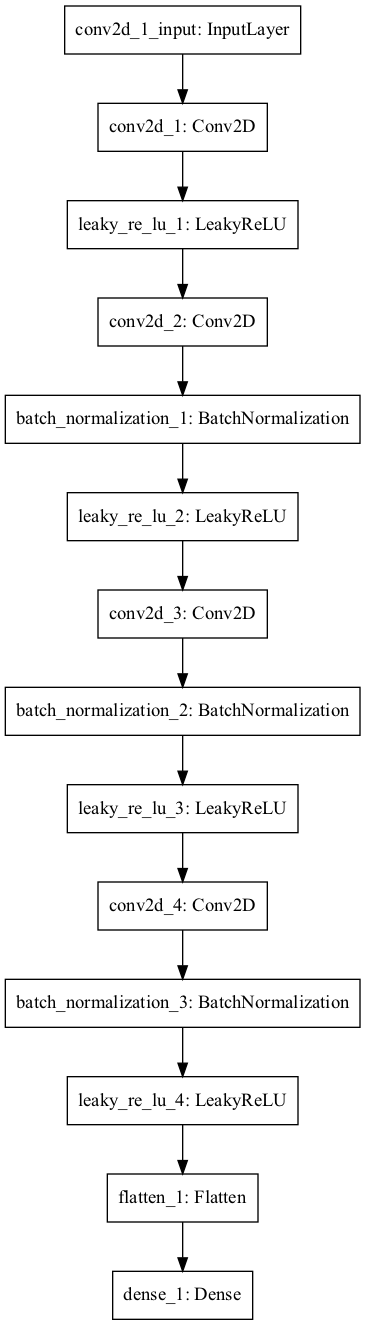

In [5]:
# model visualization
plot_model(discriminator_improv_1, to_file='discriminator_improv_1.png')

### Standalone generator model 


In [6]:
def define_generator():
    # Gaussian Weight Initialization
    init = RandomNormal(mean=0.0, stddev=0.02)
    model = Sequential()
    # Transforming the input into a 6*6 128-channel feature map 
    model.add(Dense(128*6*6,kernel_initializer=init,input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((6, 6, 128)))
   # upsample to 12x12
    model.add(Conv2DTranspose(128,4, strides=2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 24*24
    model.add(Conv2DTranspose(128,4,strides=2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 48*48
    model.add(Conv2DTranspose(64,4,strides=2, padding='same', kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    # Generator model, which maps the input of shape (dim_latent_space) into an image of shape (48,48,1)
    model.add(Conv2D(1, 7, activation='tanh', padding='same', kernel_initializer=init))
    return model

In [7]:
# model summary
generator_improv_1 = define_generator()
generator_improv_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4608)              465408    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4608)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 128)       262272    
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 24, 24, 128)      

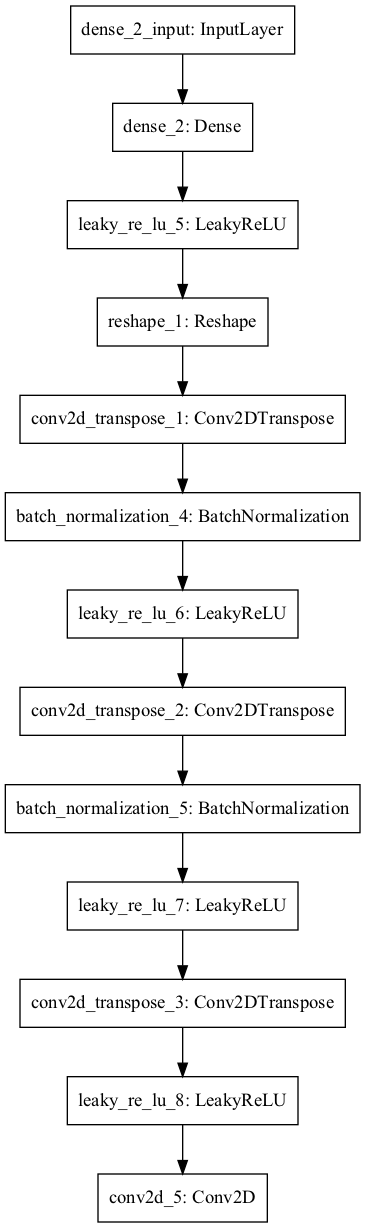

In [8]:
# model visualization
plot_model(generator_improv_1, to_file='generator_improv_1.png')


###  Keep all the rest and train

In [9]:
def define_gan(generator, discriminator):
    # Sets the discriminator weigths to non-trainable (this will only apply to the gan model)
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt =  Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# select real samples
def real_samples(dataset,batch_size):
    # choose random images
    i = randint(0, dataset.shape[0],batch_size)
    # select images
    X = dataset[i]
    # generate class labels
    y = ones((batch_size, 1))
    return X, y

def latent_points(dim_latent_space,num_points):
    # generate points in the latent space
    X_input = randn(dim_latent_space * num_points) #Return samples from the “standard normal” distribution
    # reshape into a batch of inputs for the network
    X_input = X_input.reshape(num_points, dim_latent_space)
    return X_input

def fake_samples(generator, dim_latent_space, num_points):
    # generate points in latent space
    X_input = latent_points(dim_latent_space, num_points)
    # predict outputs
    X = generator.predict(X_input)
    # create class labels
    y = zeros((num_points, 1))
    return X, y

# create a line plot of loss for the gan and save to file
def plot_history(loss1_disc,loss2_disc,g_loss_hist):
    # plot history
    plt.plot(loss1_disc, label='discriminator_real_loss')
    plt.plot(loss2_disc, label='discriminator_fake_loss')
    plt.plot(g_loss_hist, label='generator_loss')
    plt.legend()
    plt.close()

def train(generator_model, discriminator_model, gan_model, dataset, dim_latent_space, num_epochs=9, batch_size=128):
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # lists for keeping track of loss
    loss1_disc,loss2_disc, g_loss_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(num_epochs):
        loss1, loss2, g_loss = list(), list(),list()
        # enumerate batches over the training set
        for j in range(batch_per_epoch):
            # get randomly selected "real" samples
            X_real, y_real = real_samples(dataset, half_batch)
            # update discriminator model weights
            discriminator_loss1, _ = discriminator_model.train_on_batch(X_real, y_real) #train_on_batch allows you to expressly update weights based on a collection of samples you provide, without regard to any fixed batch size.
            loss1.append(discriminator_loss1)
            # generate "fake" samples
            X_fake, y_fake = fake_samples(generator_model, dim_latent_space, half_batch)
            # update discriminator model weights
            discriminator_loss2, _ = discriminator_model.train_on_batch(X_fake, y_fake)
            loss2.append(discriminator_loss2)
            # Produce points in latent space to use as the generator's input
            X_gan = latent_points(dim_latent_space,batch_size)
            # create inverted labels for the fake samples
            y_gan = ones((batch_size, 1))
            # update the generator via the discriminator's error
            generator_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_loss.append(generator_loss)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
        # store losses per epoch 
        loss1_disc.append(mean(loss1))
        loss2_disc.append(mean(loss2))
        g_loss_hist.append(mean(g_loss))
    # line plots of loss
    plot_history(loss1_disc,loss2_disc,g_loss_hist)
    # save generator model to disk
    filename = 'generator_improv_1.sav'
    pickle.dump(generator_model, open(filename, 'wb'))  

# size of the latent space
dim_latent_space = 100
# create the discriminator
discriminator_model= define_discriminator()
# create the generator
generator_model = define_generator()
# create the gan
gan_model = define_gan(generator_model, discriminator_model)
# load image data
dataset = X
# train model
train(generator_model,discriminator_model, gan_model, dataset, dim_latent_space)


/opt/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/101, d1=0.951, d2=0.721 g=1.848


/opt/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/101, d1=0.264, d2=0.699 g=1.379
>1, 3/101, d1=0.142, d2=0.555 g=1.528
>1, 4/101, d1=0.114, d2=0.215 g=1.768
>1, 5/101, d1=0.185, d2=0.122 g=1.697
>1, 6/101, d1=0.189, d2=0.144 g=1.679
>1, 7/101, d1=0.145, d2=0.062 g=1.153
>1, 8/101, d1=0.104, d2=0.069 g=0.913
>1, 9/101, d1=0.095, d2=0.047 g=0.754
>1, 10/101, d1=0.083, d2=0.029 g=0.469
>1, 11/101, d1=0.088, d2=0.057 g=0.367
>1, 12/101, d1=0.096, d2=0.021 g=0.269
>1, 13/101, d1=0.073, d2=0.025 g=0.178
>1, 14/101, d1=0.058, d2=0.020 g=0.175
>1, 15/101, d1=0.055, d2=0.018 g=0.168
>1, 16/101, d1=0.028, d2=0.020 g=0.203
>1, 17/101, d1=0.020, d2=0.013 g=0.239
>1, 18/101, d1=0.026, d2=0.018 g=0.333
>1, 19/101, d1=0.028, d2=0.029 g=0.525
>1, 20/101, d1=0.019, d2=0.023 g=0.785
>1, 21/101, d1=0.017, d2=0.036 g=1.438
>1, 22/101, d1=0.034, d2=0.054 g=2.093
>1, 23/101, d1=0.031, d2=0.037 g=2.305
>1, 24/101, d1=0.039, d2=0.052 g=3.066
>1, 25/101, d1=0.019, d2=0.051 g=3.647
>1, 26/101, d1=0.043, d2=0.046 g=3.319
>1, 27/101, d1=0.035, d2=0.017 g=

>3, 11/101, d1=0.062, d2=0.244 g=6.578
>3, 12/101, d1=0.360, d2=0.007 g=4.079
>3, 13/101, d1=0.032, d2=0.057 g=2.626
>3, 14/101, d1=0.019, d2=0.211 g=5.550
>3, 15/101, d1=0.172, d2=0.003 g=4.585
>3, 16/101, d1=0.098, d2=0.077 g=2.928
>3, 17/101, d1=0.030, d2=0.156 g=4.331
>3, 18/101, d1=0.124, d2=0.100 g=4.268
>3, 19/101, d1=0.372, d2=0.398 g=4.022
>3, 20/101, d1=0.167, d2=0.016 g=3.865
>3, 21/101, d1=0.053, d2=0.036 g=2.154
>3, 22/101, d1=0.024, d2=0.121 g=2.338
>3, 23/101, d1=0.071, d2=0.148 g=2.274
>3, 24/101, d1=0.139, d2=0.449 g=6.446
>3, 25/101, d1=1.612, d2=0.438 g=3.757
>3, 26/101, d1=0.120, d2=0.099 g=4.114
>3, 27/101, d1=0.114, d2=0.147 g=3.698
>3, 28/101, d1=0.078, d2=0.153 g=3.410
>3, 29/101, d1=0.107, d2=0.293 g=4.344
>3, 30/101, d1=0.509, d2=0.113 g=2.446
>3, 31/101, d1=0.020, d2=0.339 g=4.379
>3, 32/101, d1=0.261, d2=0.048 g=3.493
>3, 33/101, d1=0.205, d2=0.405 g=5.126
>3, 34/101, d1=0.340, d2=0.059 g=3.815
>3, 35/101, d1=0.110, d2=0.238 g=3.881
>3, 36/101, d1=0.344, d2=

>5, 20/101, d1=0.081, d2=0.064 g=3.228
>5, 21/101, d1=0.173, d2=0.199 g=3.473
>5, 22/101, d1=0.205, d2=0.095 g=2.392
>5, 23/101, d1=0.067, d2=0.229 g=5.370
>5, 24/101, d1=0.341, d2=0.089 g=2.424
>5, 25/101, d1=0.119, d2=0.326 g=3.649
>5, 26/101, d1=0.235, d2=0.074 g=1.813
>5, 27/101, d1=0.081, d2=0.276 g=2.629
>5, 28/101, d1=0.460, d2=0.210 g=2.751
>5, 29/101, d1=0.082, d2=0.343 g=5.674
>5, 30/101, d1=0.413, d2=0.128 g=4.609
>5, 31/101, d1=0.103, d2=0.132 g=5.731
>5, 32/101, d1=0.146, d2=0.149 g=5.182
>5, 33/101, d1=0.140, d2=0.582 g=7.435
>5, 34/101, d1=0.478, d2=0.070 g=3.925
>5, 35/101, d1=0.071, d2=0.099 g=2.676
>5, 36/101, d1=0.129, d2=0.189 g=3.273
>5, 37/101, d1=0.050, d2=0.452 g=6.406
>5, 38/101, d1=0.657, d2=0.032 g=4.910
>5, 39/101, d1=0.144, d2=0.297 g=6.043
>5, 40/101, d1=0.160, d2=0.035 g=4.852
>5, 41/101, d1=0.193, d2=0.741 g=6.682
>5, 42/101, d1=0.202, d2=0.010 g=6.107
>5, 43/101, d1=0.409, d2=0.100 g=2.377
>5, 44/101, d1=0.154, d2=0.186 g=2.408
>5, 45/101, d1=0.067, d2=

>7, 29/101, d1=0.189, d2=0.218 g=3.219
>7, 30/101, d1=0.078, d2=0.036 g=4.323
>7, 31/101, d1=0.201, d2=0.113 g=2.836
>7, 32/101, d1=0.126, d2=0.262 g=5.501
>7, 33/101, d1=0.127, d2=0.015 g=5.630
>7, 34/101, d1=0.197, d2=0.147 g=4.908
>7, 35/101, d1=0.027, d2=0.043 g=5.059
>7, 36/101, d1=0.084, d2=0.088 g=5.140
>7, 37/101, d1=0.056, d2=0.085 g=5.603
>7, 38/101, d1=0.142, d2=0.143 g=4.982
>7, 39/101, d1=0.235, d2=0.161 g=3.987
>7, 40/101, d1=0.138, d2=0.240 g=4.207
>7, 41/101, d1=0.141, d2=0.003 g=2.028
>7, 42/101, d1=0.187, d2=0.032 g=0.092
>7, 43/101, d1=0.030, d2=0.187 g=0.391
>7, 44/101, d1=0.100, d2=0.019 g=0.372
>7, 45/101, d1=0.021, d2=0.030 g=0.297
>7, 46/101, d1=0.075, d2=0.309 g=3.277
>7, 47/101, d1=0.672, d2=0.314 g=1.964
>7, 48/101, d1=0.121, d2=0.031 g=1.568
>7, 49/101, d1=0.037, d2=0.055 g=1.385
>7, 50/101, d1=0.056, d2=0.021 g=0.635
>7, 51/101, d1=0.012, d2=0.109 g=1.258
>7, 52/101, d1=0.098, d2=0.046 g=0.679
>7, 53/101, d1=0.159, d2=0.545 g=4.211
>7, 54/101, d1=0.802, d2=

>9, 38/101, d1=0.160, d2=0.034 g=3.576
>9, 39/101, d1=0.027, d2=0.154 g=4.485
>9, 40/101, d1=0.258, d2=0.342 g=4.777
>9, 41/101, d1=0.316, d2=0.107 g=3.427
>9, 42/101, d1=0.039, d2=0.077 g=3.396
>9, 43/101, d1=0.099, d2=0.254 g=4.798
>9, 44/101, d1=0.327, d2=0.278 g=5.576
>9, 45/101, d1=0.337, d2=0.052 g=3.096
>9, 46/101, d1=0.054, d2=0.280 g=4.206
>9, 47/101, d1=0.252, d2=0.043 g=2.136
>9, 48/101, d1=0.112, d2=0.295 g=3.011
>9, 49/101, d1=0.287, d2=0.206 g=3.660
>9, 50/101, d1=0.318, d2=0.347 g=5.456
>9, 51/101, d1=0.310, d2=0.049 g=3.758
>9, 52/101, d1=0.077, d2=0.309 g=5.913
>9, 53/101, d1=0.416, d2=0.052 g=3.647
>9, 54/101, d1=0.027, d2=0.197 g=4.814
>9, 55/101, d1=0.123, d2=0.029 g=4.362
>9, 56/101, d1=0.161, d2=0.217 g=4.301
>9, 57/101, d1=0.118, d2=0.086 g=4.537
>9, 58/101, d1=0.109, d2=0.161 g=4.834
>9, 59/101, d1=0.236, d2=0.500 g=6.340
>9, 60/101, d1=1.195, d2=0.821 g=5.921
>9, 61/101, d1=0.263, d2=0.033 g=4.765
>9, 62/101, d1=0.103, d2=0.234 g=5.261
>9, 63/101, d1=0.268, d2=

### Loading the generator model and generating images

/opt/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


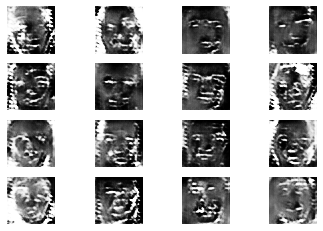

In [10]:
# create and save a plot of generated images (reversed grayscale)
def g_img_plot(samples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(samples[i, :, :, 0], cmap='gray_r')
    plt.show()

# load the model from disk
model = pickle.load(open('generator_improv_1.sav', 'rb'))
# generate images
latent_points = latent_points(100, 100)
# generate images
output = model.predict(latent_points)
# plot generated images
g_img_plot(output, 4)